In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from skl2onnx import to_onnx
import cv2
import random
from xgboost import XGBClassifier
import mlflow
import dotenv
import seaborn as sns
import warnings
from onnxruntime import InferenceSession
import json

warnings.simplefilter("ignore", category=FutureWarning)
dotenv.load_dotenv()
mlflow.set_tracking_uri("https://dagshub.com/izzalDev/car-computer-vision.mlflow")
mlflow.set_experiment("SVM Classifier")

<Experiment: artifact_location='mlflow-artifacts:/0f69ae43dd274e849b24ad5898dd1259', creation_time=1717823781627, experiment_id='2', last_update_time=1717823781627, lifecycle_stage='active', name='SVM Classifier', tags={}>

In [58]:
def load_images_and_labels(data_dir):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                images.append(image)
                labels.append(os.path.basename(root))
    return images, labels

In [59]:
def show_sample_images(images, y=None, reshape=None, cmap=None):
    fig, axs = plt.subplots(5, 5, figsize=(12, 12))
    for i in range(25):
        img_num = random.randint(0, len(images)-1)
        axs[i//5, i%5].imshow(images[img_num].reshape(reshape), cmap=cmap)
        axs[i//5, i%5].axis('off')
        axs[i//5, i%5].title.set_text(y[img_num]) if y is not None else None
    plt.show()

In [60]:
DATA_DIR = 'data/classification'
images, labels = load_images_and_labels(DATA_DIR)

# Overview Dataset Mobil

Dataset ini berisi gambar mobil yang dikategorikan ke dalam empat kelas utama: Citicar, Sedan, Sport, dan Van. Setiap gambar memiliki tiga saluran warna (RGB) yang merepresentasikan warna merah, hijau, dan biru.

**Informasi Dataset:**

- **Jumlah Gambar:** 2014
- **Kelas Utama:** Citicar, Sedan, Sport, Van
- **Saluran Warna:** RGB (Red, Green, Blue)

Dataset ini dapat digunakan untuk berbagai tujuan, termasuk pelatihan dan pengujian model pengenalan gambar untuk mengklasifikasikan jenis-jenis mobil. Dengan jumlah gambar yang cukup besar dan representatif dari berbagai kelas, dataset ini memberikan kesempatan untuk pengembangan model yang akurat dan andal dalam mengidentifikasi mobil-mobil berbeda dalam gambar.

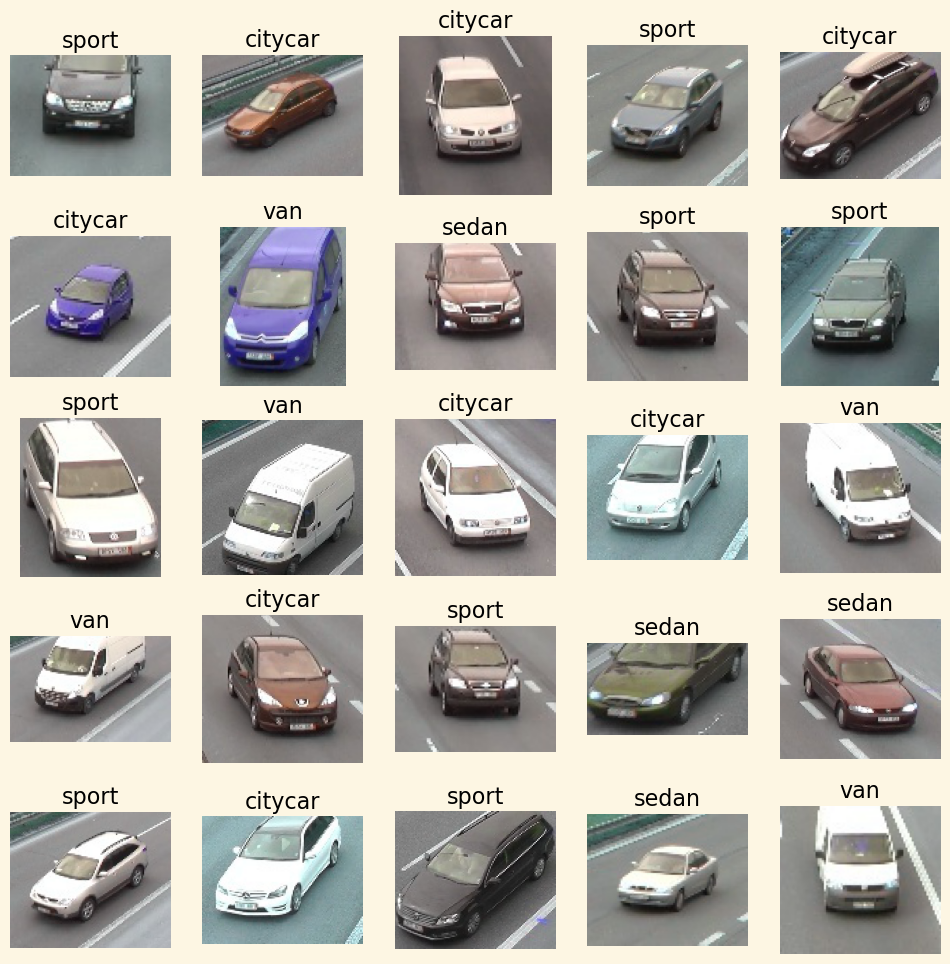

In [61]:
show_sample_images(images, labels, reshape=None)

## Distribusi Kelas

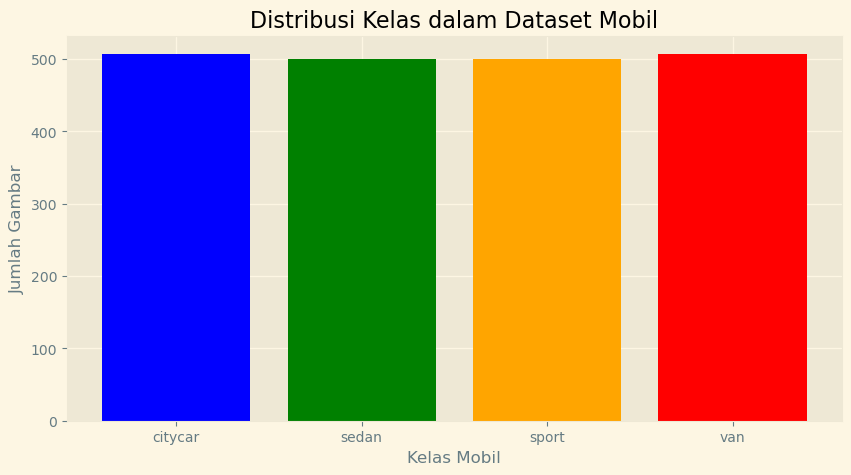

In [62]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

plt.figure(figsize=(10, 5))
plt.bar(label_encoder.classes_, np.bincount(y), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Kelas Mobil')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Kelas dalam Dataset Mobil')
plt.show()

Distribusi kelas dalam dataset ini terlihat seimbang, dengan jumlah gambar yang cukup merata di setiap kelas. Tidak ada perbedaan yang signifikan antara jumlah gambar yang mewakili setiap kelas, menunjukkan distribusi yang seimbang secara relatif di antara kelas-kelas tersebut.

## Distribusi Warna

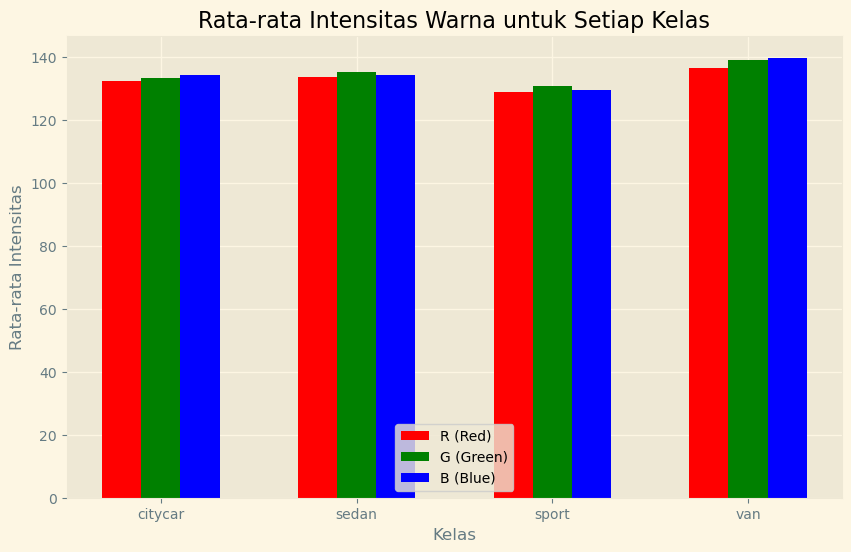

In [63]:
def calculate_mean_color(images, labels):
    # Mendefinisikan kelas unik
    unique_labels = list(set(labels))
    
    # Inisialisasi dictionary untuk menyimpan rata-rata intensitas warna untuk setiap kelas
    mean_colors = {label: [0, 0, 0] for label in unique_labels}
    
    # Loop melalui setiap gambar dan label
    for image, label in zip(images, labels):
        # Hitung rata-rata intensitas warna merah, hijau, dan biru
        mean_color = np.mean(image, axis=(0, 1))
        
        # Tambahkan rata-rata intensitas warna ke dalam dictionary
        mean_colors[label][0] += mean_color[0]
        mean_colors[label][1] += mean_color[1]
        mean_colors[label][2] += mean_color[2]
    
    # Bagi rata-rata intensitas warna dengan jumlah gambar dalam setiap kelas untuk mendapatkan rata-rata
    jumlah_gambar_kelas = {label: labels.count(label) for label in unique_labels}
    for label in unique_labels:
        total_gambar_kelas = jumlah_gambar_kelas[label]
        mean_colors[label] = [value / total_gambar_kelas for value in mean_colors[label]]
    
    return mean_colors

# Menghitung rata-rata intensitas warna untuk setiap kelas
mean_colors = calculate_mean_color(images, labels)

# Ekstraksi nilai intensitas untuk setiap warna dan kelas
kelas = list(mean_colors.keys())
r = [mean_colors[label][0] for label in kelas]
g = [mean_colors[label][1] for label in kelas]
b = [mean_colors[label][2] for label in kelas]

# Plot bar
x = np.arange(len(kelas))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, r, width, label='R (Red)', color='r')
rects2 = ax.bar(x, g, width, label='G (Green)', color='g')
rects3 = ax.bar(x + width, b, width, label='B (Blue)', color='b')

# Label dan judul
ax.set_xlabel('Kelas')
ax.set_ylabel('Rata-rata Intensitas')
ax.set_title('Rata-rata Intensitas Warna untuk Setiap Kelas')
ax.set_xticks(x)
ax.set_xticklabels(kelas)
ax.legend()

plt.show()

## Distribusi Ukuran

Plotting distribusi ukuran gambar (jumlah nilai dalam vektor gambar: $tinggi*lebar*channels$)

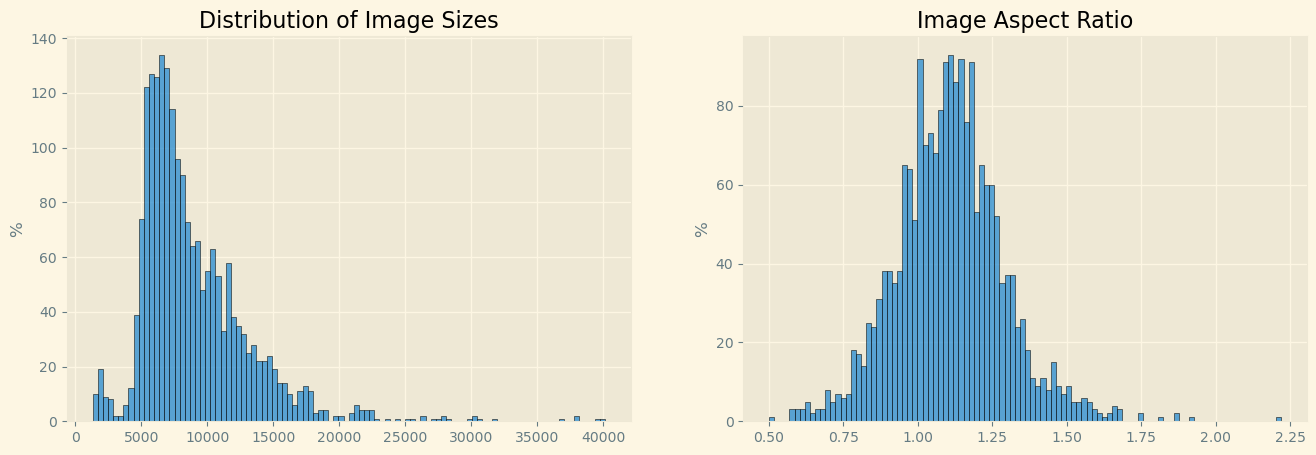

In [64]:
import seaborn as sns
plt.style.use('Solarize_Light2')

image_sizes = [image.shape[0] * image.shape[1] for image in images]
aspect_ratios = [image.shape[1] / image.shape[0] for image in images]

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(x=image_sizes, bins=100, ax=ax[0])
ax[0].set_title("Distribution of Image Sizes")
ax[0].set_ylabel("%")

sns.histplot(x=aspect_ratios, bins=100, ax=ax[1])
ax[1].set_title("Image Aspect Ratio")
ax[1].set_ylabel("%")

plt.show()

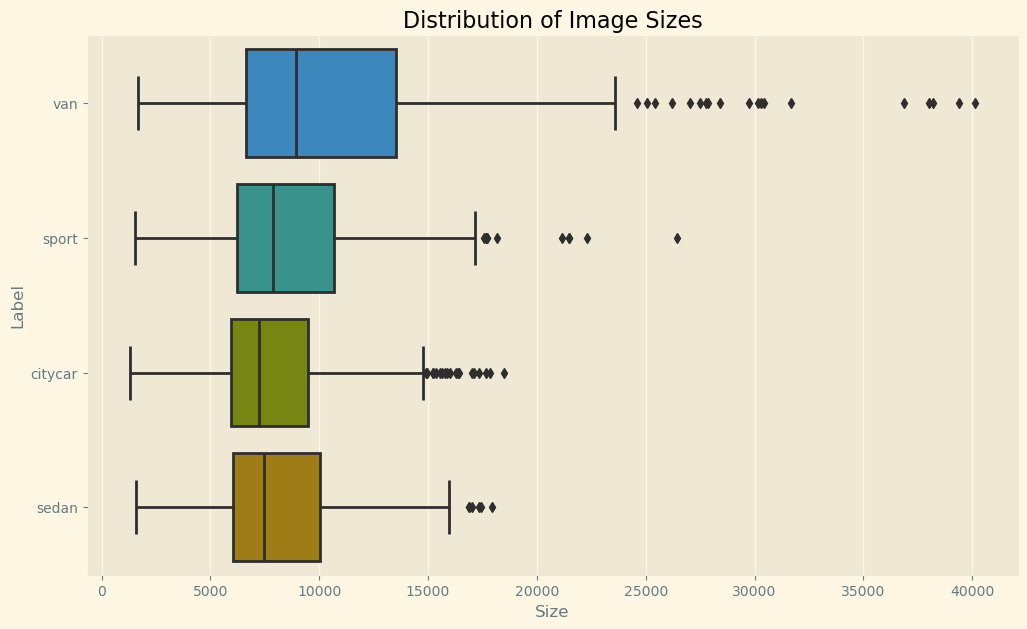

In [65]:
plt.figure(figsize=(12, 7))

ax = sns.boxplot(y=labels, x=image_sizes, orient="h")
plt.title("Distribution of Image Sizes")
plt.ylabel("Label")
plt.xlabel("Size")
plt.show()

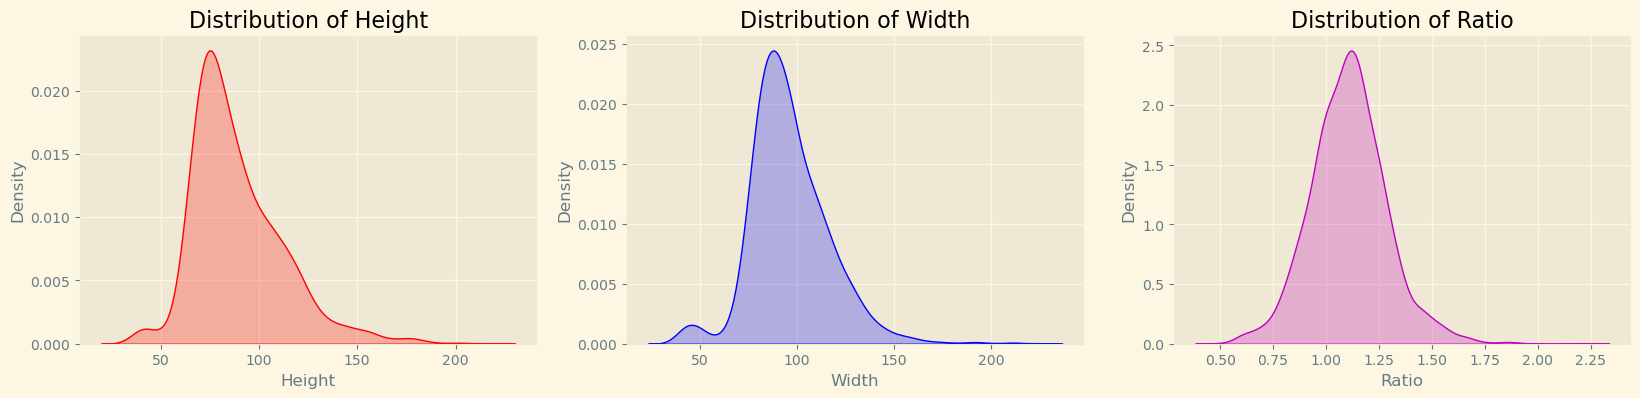

In [66]:
heights = [image.shape[0] for image in images]
widths = [image.shape[1] for image in images]
ratios = [image.shape[1] / image.shape[0] for image in images]

# Plotting distributions
f, axes = plt.subplots(figsize=(20, 4), ncols=3, nrows=1)

sns.kdeplot(heights, ax=axes[0], color="r", fill=True)
sns.kdeplot(widths, ax=axes[1], color="b", fill=True)
sns.kdeplot(ratios, ax=axes[2], color="m", fill=True)

axes[0].set_xlabel("Height")
axes[1].set_xlabel("Width")
axes[2].set_xlabel("Ratio")

axes[0].set_title('Distribution of Height')
axes[1].set_title('Distribution of Width')
axes[2].set_title('Distribution of Ratio')

plt.show()

In [67]:
mean_ratio = np.mean(ratios)
scale_height = 32
scale_width = int(scale_height * mean_ratio)

print(f"Rescaling to h: {int(scale_height)}, w: {int(scale_width)}");

Rescaling to h: 32, w: 35


# Preprocessing

In [68]:
def preprocess_images(images):
    processed_images = []
    for image in images:
        image = cv2.resize(image, (scale_width, scale_height))
        processed_images.append(image.flatten())
    return np.array(processed_images)


In [69]:
X = preprocess_images(images)

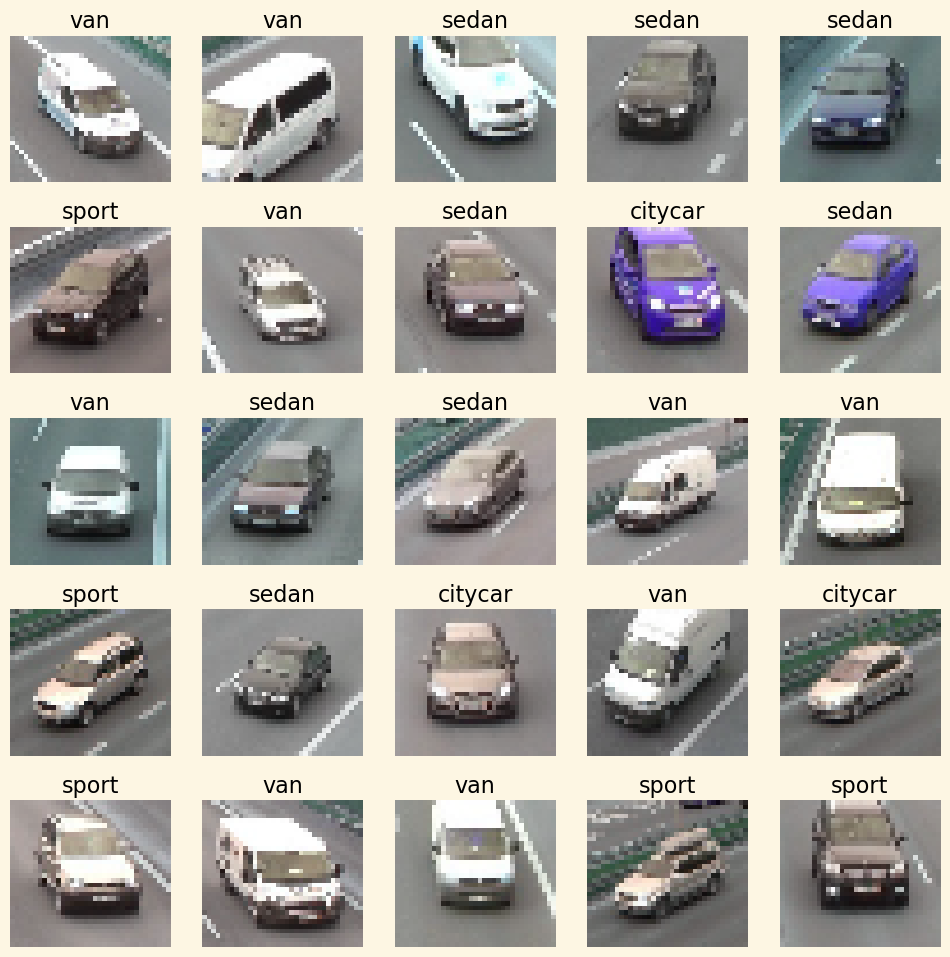

In [70]:
show_sample_images(X, labels, reshape=(scale_height, scale_width, 3), cmap=None)

# Data Splitting

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(images), np.unique(labels))

2014 ['citycar' 'sedan' 'sport' 'van']


# Modelling

In [72]:
# Tentukan pipeline model
from sklearn.model_selection import RandomizedSearchCV


model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True)),
])

grid_params = {
    'classifier__gamma': [1e-1],
    'classifier__C': [1e-3],
    'classifier__kernel': ['poly'],
}

clf = RandomizedSearchCV(model_pipeline, grid_params, verbose=3, cv=10, scoring='accuracy', n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/homebrew/Caskroom/miniconda/base/envs/comvis/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 7/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.627 total time= 1.6min
[CV 3/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.652 total time= 1.6min
[CV 4/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.602 total time= 1.6min
[CV 6/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.627 total time= 1.7min
[CV 2/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.671 total time= 1.7min
[CV 8/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.658 total time= 1.7min
[CV 5/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.683 total time= 1.7min
[CV 1/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=poly;, score=0.574 total time= 1.7min
[CV 9/10] END classifier__C=0.001, classifier__gamma=0.1, classifier__kernel=pol

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              SVC(probability=True))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.001],
                                        'classifier__gamma': [0.1],
                                        'classifier__kernel': ['poly']},
                   scoring='accuracy', verbose=3)

In [73]:
best_model = clf.best_estimator_
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

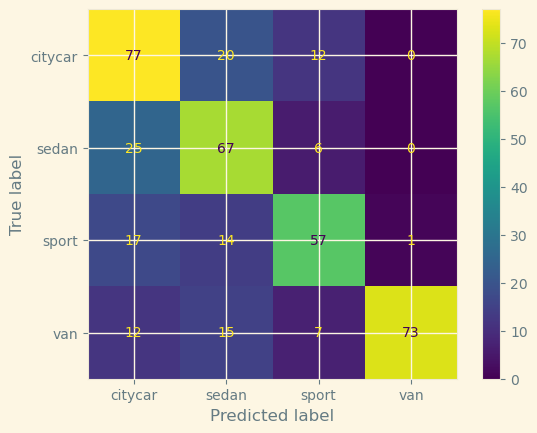

In [74]:
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)

In [75]:
onnx = to_onnx(best_model, X_test[:1].astype(np.float32), options={"zipmap": False})

In [76]:
sess = InferenceSession(onnx.SerializeToString())

pred_ort = sess.run(None, {"X": X_test[:5].astype(np.float32)})
pred_skl = best_model.predict(X_test[:5].astype(np.float32))

print("Onnx Runtime prediction:\n", pred_ort)
print("Sklearn prediction:\n", pred_skl)

Onnx Runtime prediction:
 [array([0, 2, 0, 0, 1], dtype=int64), array([[0.50809115, 0.2699089 , 0.16779913, 0.05420096],
       [0.03949143, 0.05142701, 0.35785013, 0.5512313 ],
       [0.3383819 , 0.08181982, 0.16073205, 0.4190664 ],
       [0.3778676 , 0.18461695, 0.23331925, 0.20419624],
       [0.13320297, 0.4220202 , 0.27681255, 0.1679643 ]], dtype=float32)]
Sklearn prediction:
 [0 2 0 0 1]


In [77]:
class_names = dict(enumerate(map(str, label_encoder.classes_)))
m1 = onnx.metadata_props.add()
m1.key = 'class_names'
m1.value = json.dumps(class_names)

m2 = onnx.metadata_props.add()
m2.key = 'cmap'
m2.value = 'BGR'

m3 = onnx.metadata_props.add()
m3.key = 'preprocessing'
m3.value = json.dumps({
    'resize': {
        'height': scale_height,
        'width': scale_width,
    },
    'flatten': True,
})

In [78]:
with open('models/model.onnx', 'wb') as f:
    f.write(onnx.SerializeToString()) # type: ignore


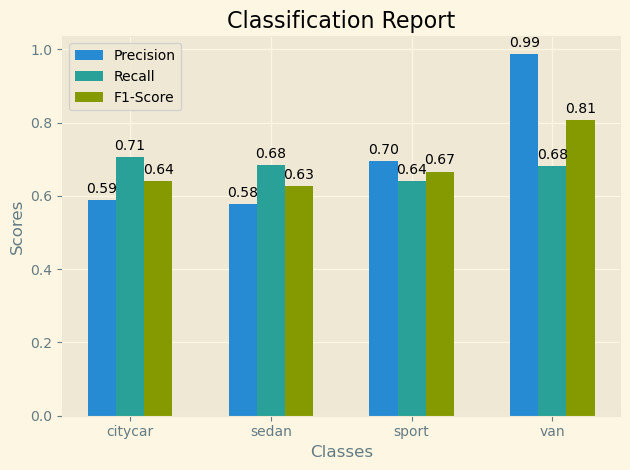

In [79]:
# Extract metrics from the report
metrics = ['precision', 'recall', 'f1-score']
classes = label_encoder.classes_

# Create a list of values for each metric
data = {metric: [report[cls][metric] for cls in classes] for metric in metrics}

# Create a bar plot
x = np.arange(len(classes))  # Label locations
width = 0.2  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, data['precision'], width, label='Precision')
rects2 = ax.bar(x, data['recall'], width, label='Recall')
rects3 = ax.bar(x + width, data['f1-score'], width, label='F1-Score')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

In [80]:
import mlflow
import mlflow.onnx
from mlflow.models.signature import ModelSignature
from mlflow.types import Schema, ColSpec, TensorSpec

input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 3360), 'X')])

output_schema = Schema([
    TensorSpec(np.dtype(np.int64), (-1,), 'label'),
    TensorSpec(np.dtype(np.float32), (-1, 4), 'probabilities'),
])

signature = ModelSignature(inputs=input_schema, outputs=output_schema)

with mlflow.start_run():
    mlflow.onnx.log_model(
        onnx, "model", 
        input_example=X_test[:1].astype(np.float32), 
        signature=signature,
        metadata={
            m1.key: m1.value,
            m2.key: m2.value,
            m3.key: m3.value
        }
    )
    mlflow.log_params(clf.best_params_)
    mlflow.log_metrics({'val_accuracy': clf.best_score_})
    mlflow.log_metrics({'accuracy': report['accuracy']})
    mlflow.log_metrics({'recall': report['macro avg']['recall']})
    mlflow.log_metrics({'precision': report['macro avg']['precision']})
    mlflow.log_metrics({'f1': report['macro avg']['f1-score']})
    mlflow.log_figure(conf_matrix.figure_, 'confusion_matrix.png')
    mlflow.log_figure(fig, 'classification_report.png')
    mlflow.log_table(report, 'report.json')